<a href="https://colab.research.google.com/github/galopyz/hprc/blob/main/circadian6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Ensembling

Testing Bulk data. We create a new dataframe that has the same columns as the bulk data. Then we test on the bulkdata (test data).

- With dropout, the model reached 92% on bulk data.
- Hihger accuracy on traning data does not necessarily mean high test accuracy.

### TODO
- Try ensembling:
  - With random seeds, there are too many variability in results.
  - Hopefully ensembling may provide better results
- Try data augmentation.
  - Random swap: swapping random columns.
- Try a new loss function.
  - Hexagon (7x8) with MSELoss
  1. Predict 56 outputs
  2. Create a hexagon
  3. MSE with the target
- Try Random Forest.
- Try Gradient boosting.

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/'Colab Notebooks'
!pip -q install torcheval
!pip -q install datasets

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks


In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import torch
from torch import tensor
from torcheval.metrics import MulticlassAccuracy
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.augment import *
from miniai.xtras import *

In [3]:
path = Path('./data/circadian/')

In [4]:
t = np.zeros((7, 8))
t

array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.]])

In [5]:
t0 = (0,5)
t1 = (3,7)
t2 = (6,5)
t3 = (6,2)
t4 = (3,0)
t5 = (0,2)
coords = [t0, t1, t2, t3, t4, t5]

In [6]:
for c in coords:
    t[c] = 1

In [7]:
t

array([[0., 0., 1., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 1., 0., 0.]])

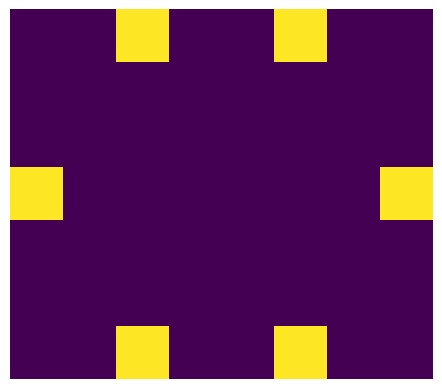

In [8]:
show_image(t);

## Data

Preparing scRNA-seq data for training.

In [9]:
meta_data = pd.read_csv(path/'meta_data.csv', low_memory=False)
raw_data = pd.read_csv(path/'RNA_count_mat.csv', low_memory=False)
data = raw_data.set_index('gene').T
# Normalizing the data to have mean of 0 and standard deviation of 1
data = (data - data.mean(axis=0)) / data.std(axis=0)
df = data.join(meta_data.set_index('cell_name'))
df['ZT'] = pd.Categorical(df['ZT'])
df['code'] = df['ZT'].cat.codes

In [10]:
df['ZT']

AAACAGCCAACCCTAA-6    ZT18
AAACCAACAGTAAAGC-6    ZT18
AAACCGAAGGTCCTAG-6    ZT18
AAAGCACCATTGTCCT-6    ZT18
AAAGGACGTGAGGTGA-6    ZT18
                      ... 
TTGCCCGTCGCACAAT-7    ZT06
TTGCGTCTCTTAGTCT-7    ZT06
TTGGGTTAGCCACAAT-7    ZT06
TTTAGCTTCAGGAAGC-7    ZT06
TTTGGTAAGGAAGTAT-7    ZT06
Name: ZT, Length: 15992, dtype: category
Categories (6, object): ['ZT02', 'ZT06', 'ZT10', 'ZT14', 'ZT18', 'ZT22']

In [11]:
df['ZT'].cat.codes

AAACAGCCAACCCTAA-6    4
AAACCAACAGTAAAGC-6    4
AAACCGAAGGTCCTAG-6    4
AAAGCACCATTGTCCT-6    4
AAAGGACGTGAGGTGA-6    4
                     ..
TTGCCCGTCGCACAAT-7    1
TTGCGTCTCTTAGTCT-7    1
TTGGGTTAGCCACAAT-7    1
TTTAGCTTCAGGAAGC-7    1
TTTGGTAAGGAAGTAT-7    1
Length: 15992, dtype: int8

In [12]:
df[:3]

,Meg3,Slc1a2,Rian,Cyp2c40,Cyp2c69,Sgcz,Glul,Ugt2b37,Tmeff2,B830012L14Rik,...,Mpp6,Ralgps1,Zfp580,Sept8,Cfap52,Arhgap27,F730043M19Rik,Bora,ZT,code
AAACAGCCAACCCTAA-6,-0.094012,-0.251429,-0.084206,-0.118838,-0.084834,-0.183315,-0.255395,-0.062888,-0.092432,-0.073209,...,1.122616,2.084872,-0.036734,-0.036734,-0.036734,-0.036734,-0.036734,-0.318222,ZT18,4
AAACCAACAGTAAAGC-6,-0.094012,-0.032904,-0.084206,-0.118838,-0.084834,-0.183315,-0.255395,-0.062888,-0.092432,-0.073209,...,-0.554376,-0.619790,-0.036734,-0.036734,-0.036734,-0.036734,-0.036734,2.058709,ZT18,4
AAACCGAAGGTCCTAG-6,-0.094012,-0.251429,-0.084206,-0.118838,-0.084834,-0.183315,-0.255395,-0.062888,-0.092432,-0.073209,...,0.451819,0.281764,-0.036734,-0.036734,-0.036734,-0.036734,-0.036734,-0.318222,ZT18,4


In [13]:
raw_bulk_data = pd.read_csv(path/'RNA.csv', low_memory=False)
bulk_data = raw_bulk_data.set_index('ID').T
bulk_data = (bulk_data - bulk_data.mean(axis=0)) / bulk_data.std(axis=0)
bulk_data['code'] = [0,1,2,3,4,5,0,1,2,3,4,5]

The bulk data contains more columns than scRNA-seq data.

In [14]:
cols = set(list(df.columns) + list(bulk_data.columns))
len(cols)

10910

### Bulk + scRNA-seq

Instead of joining tables, we create a new table with the same shape as the bulk data with normally distributed random numbers. Then, we overwrite columns from scRNA-seq into this new table.

In [15]:
# New dataframe (table) with normally distributed random numbers
df2 = pd.DataFrame(np.random.normal(size=(15992, 9482)), columns=bulk_data.columns)
df.reset_index(inplace=True)
df2.update(df)
df2[:3]

ID,2810459M11Rik,Abcb11,Acot7,Ahctf1,Ap2a2,Asb13,Asl,Chka,Clic3,Clpx,...,Ap1s3,Vamp4,Pigm,Pard6g,Gas2,Pot1b,Zfp759,Neo1,Sco1,code
0,-1.673128,1.084080,0.038466,-0.004780,-0.601919,-0.071131,-0.043890,1.686979,-0.327150,0.234600,...,-0.166754,0.079255,-2.592855,1.550299,2.159961,-0.401256,0.035899,0.542793,0.651020,4.0
1,-0.805391,-0.872108,0.508653,0.160614,-0.532530,-0.641520,-0.387448,-0.189915,-0.134418,-0.363165,...,-0.166754,-1.080095,0.429537,-0.286616,-0.784713,-0.401256,0.789824,0.088444,-1.541891,4.0
2,0.399730,0.738870,-1.281375,0.257980,0.205694,-1.766349,1.673901,0.122900,-1.406753,1.131247,...,10.777388,0.737111,1.241127,1.544991,0.821473,-0.401256,0.392862,0.668692,-1.265510,4.0


## Using Pytorch

In [16]:
t_dep = tensor(df2['code'], dtype=torch.long)
indep_cols = list(df2.columns)[:-1]
t_indep = tensor(df2[indep_cols].values, dtype=torch.float32)

In [17]:
tst_dep = tensor(bulk_data['code'], dtype=torch.long)
tst_indep_cols = list(bulk_data.columns)[:-1]
tst_indep = tensor(bulk_data[indep_cols].values, dtype=torch.float32)
tst_indep

tensor([[ 1.1054,  1.7349, -1.0005,  ...,  0.1433, -0.5614, -0.5629],
        [ 0.1407,  0.3628,  0.2168,  ..., -1.1979,  1.1994,  0.0943],
        [-0.8167, -1.0595,  0.3766,  ...,  1.8283, -1.9395, -1.7678],
        ...,
        [-0.6048, -1.0751,  0.9168,  ...,  0.1089, -0.2552, -0.3438],
        [ 0.4233,  0.0204,  0.0723,  ..., -1.3010, -0.1021, -1.0376],
        [ 1.0372,  0.7136, -0.5212,  ...,  1.8627,  0.4338, -0.7820]])

In [18]:
from fastai.data.transforms import RandomSplitter
trn_split,val_split=RandomSplitter(seed=42)(df2)

In [19]:
trn_indep,val_indep = t_indep[trn_split],t_indep[val_split]
trn_dep,val_dep = t_dep[trn_split],t_dep[val_split]
len(trn_indep),len(val_indep)

(12794, 3198)

### DataLoaders

Pretty much the same as the previous approach with bulk data as the test data.

In [20]:
# set_seed(42)
trn_dl = DataLoader(list(zip(trn_indep, trn_dep)), batch_size=64, shuffle=True)
val_dl = DataLoader(list(zip(val_indep, val_dep)), batch_size=64, shuffle=True)
dls = DataLoaders(trn_dl, val_dl)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

(torch.Size([64, 9481]), tensor([0, 4, 5, 0, 0, 5, 2, 2, 2, 3]))

In [21]:
tst_dl = DataLoader(list(zip(tst_indep, tst_dep)), shuffle=False)

In [22]:
metrics = MetricsCB(accuracy=MulticlassAccuracy(device='cpu'))
astats = ActivationStats(nn.ReLU)
cbs = [DeviceCB(), metrics, ProgressCB(plot=False), astats]

In [23]:
# set_seed(42)
model = nn.Sequential(*[nn.Linear(9481, 100), nn.ReLU(), nn.Linear(100, 100), nn.ReLU(), nn.Linear(100, 6)])
learn = TrainLearner(model, dls, lr=.01, loss_func=F.cross_entropy, cbs=cbs)

In [24]:
learn.summary()

Tot params: 958906; MFLOPS: 1.0


|Module|Input|Output|Num params|MFLOPS|
|--|--|--|--|--|
|Linear|(64, 9481)|(64, 100)|948200|0.9|
|ReLU|(64, 100)|(64, 100)|0|0.0|
|Linear|(64, 100)|(64, 100)|10100|0.0|
|ReLU|(64, 100)|(64, 100)|0|0.0|
|Linear|(64, 100)|(64, 6)|606|0.0|


## Data Augmentation

We randomly select two columns and swap them.

In [25]:
xb,_ = next(iter(dls.train))
xbt = xb[:5,:10]
xbt

tensor([[ 0.5811, -0.5844, -1.3904, -0.5621,  0.2893,  1.1827, -0.7310, -0.1899,
         -0.7998,  0.2346],
        [ 0.4563, -0.6995, -0.8255,  1.3435,  2.0367,  2.3283, -0.3874, -0.6591,
          0.7168, -0.8115],
        [ 0.8756,  1.3142,  0.8828,  2.1354, -1.0790, -0.4113, -0.0439,  0.4357,
          0.1252,  2.3268],
        [ 0.6159, -0.7570, -1.0327, -0.7189,  0.0739, -0.4211, -0.0439, -0.8155,
         -0.0296, -0.8115],
        [-1.6423,  1.0265,  2.4759,  0.1268,  1.3292, -0.5343, -0.3874,  0.9049,
         -1.7094,  2.0279]])

In [26]:
tmp = xbt[:,1].detach().clone()
xbt[:,1] = xbt[:,0]
xbt[:,0] = tmp
xbt

tensor([[-0.5844,  0.5811, -1.3904, -0.5621,  0.2893,  1.1827, -0.7310, -0.1899,
         -0.7998,  0.2346],
        [-0.6995,  0.4563, -0.8255,  1.3435,  2.0367,  2.3283, -0.3874, -0.6591,
          0.7168, -0.8115],
        [ 1.3142,  0.8756,  0.8828,  2.1354, -1.0790, -0.4113, -0.0439,  0.4357,
          0.1252,  2.3268],
        [-0.7570,  0.6159, -1.0327, -0.7189,  0.0739, -0.4211, -0.0439, -0.8155,
         -0.0296, -0.8115],
        [ 1.0265, -1.6423,  2.4759,  0.1268,  1.3292, -0.5343, -0.3874,  0.9049,
         -1.7094,  2.0279]])

In [27]:
import random
random.randint

<bound method Random.randint of <random.Random object at 0x5c1488794180>>

In [28]:
def _random_swap(x):
    """Swap two columns randomly."""
    n_cols = x.shape[1]
    a = random.randint(0, n_cols-1)
    b = random.randint(0, n_cols-1)
    tmp = x[:,a].detach().clone()
    x[:,a] = x[:,b]
    x[:,b] = tmp
    return x

In [29]:
_random_swap(xbt)

tensor([[-0.5844,  1.1827, -1.3904, -0.5621,  0.2893,  0.5811, -0.7310, -0.1899,
         -0.7998,  0.2346],
        [-0.6995,  2.3283, -0.8255,  1.3435,  2.0367,  0.4563, -0.3874, -0.6591,
          0.7168, -0.8115],
        [ 1.3142, -0.4113,  0.8828,  2.1354, -1.0790,  0.8756, -0.0439,  0.4357,
          0.1252,  2.3268],
        [-0.7570, -0.4211, -1.0327, -0.7189,  0.0739,  0.6159, -0.0439, -0.8155,
         -0.0296, -0.8115],
        [ 1.0265, -0.5343,  2.4759,  0.1268,  1.3292, -1.6423, -0.3874,  0.9049,
         -1.7094,  2.0279]])

In [30]:
def random_swap(x, max_swaps=10):
    """Swap two columns randomly by picking a random number."""
    swaps = random.randint(0, 10)
    _random_swap(x)
    return x

In [31]:
random_swap(xbt)

tensor([[ 0.2893,  1.1827, -1.3904, -0.5621, -0.5844,  0.5811, -0.7310, -0.1899,
         -0.7998,  0.2346],
        [ 2.0367,  2.3283, -0.8255,  1.3435, -0.6995,  0.4563, -0.3874, -0.6591,
          0.7168, -0.8115],
        [-1.0790, -0.4113,  0.8828,  2.1354,  1.3142,  0.8756, -0.0439,  0.4357,
          0.1252,  2.3268],
        [ 0.0739, -0.4211, -1.0327, -0.7189, -0.7570,  0.6159, -0.0439, -0.8155,
         -0.0296, -0.8115],
        [ 1.3292, -0.5343,  2.4759,  0.1268,  1.0265, -1.6423, -0.3874,  0.9049,
         -1.7094,  2.0279]])

In [32]:
class RandomSwap(nn.Module):
    def __init__(self, max_swaps=10):
        super().__init__()
        self.max_swaps = max_swaps

    def forward(self, x):
        return random_swap(x, self.max_swaps)

In [33]:
def tfm_batch(b, tfm_x=fc.noop, tfm_y = fc.noop): return tfm_x(b[0]),tfm_y(b[1])

In [34]:
from functools import partial

In [35]:
tfms = nn.Sequential(RandomSwap(3000))
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

In [36]:
# set_seed(42)
model = nn.Sequential(*[nn.Linear(9481, 100), nn.ReLU(), nn.Linear(100, 100), nn.ReLU(), nn.Linear(100, 6)])

In [37]:
cbs = cbs

In [38]:
learn = TrainLearner(model, dls, F.cross_entropy, lr=1, cbs=[SingleBatchCB(), augcb])
learn.fit(1)
xb,yb = learn.batch
xb[:5,:10]

tensor([[ 0.3401, -0.9296, -0.5143, -0.2942,  1.1228,  0.2970, -0.7310, -0.8155,
         -1.2767, -0.8115],
        [ 2.1162, -0.3543,  0.2189,  0.2186, -0.6024, -0.5370,  2.0175,  0.2793,
         -0.9936, -0.3632],
        [ 1.7662, -0.7570, -0.4153,  0.5182, -0.6846, -1.2205,  3.0481, -0.6591,
         -0.7852, -0.6620],
        [-0.5363,  1.0265, -1.3745,  1.1991,  1.4529, -0.0482, -0.0439,  1.9998,
          1.4343,  1.4301],
        [-0.1378, -0.3543,  1.5490, -0.1799,  1.5770,  1.3616, -0.0439, -0.5027,
         -1.0473, -0.5126]])

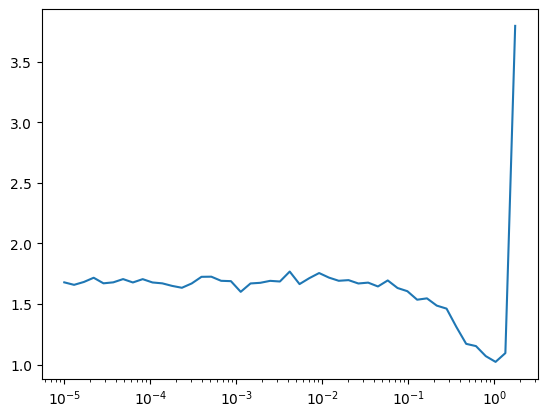

In [39]:
TrainLearner(model, dls, lr=.01, loss_func=F.cross_entropy, cbs=cbs).lr_find()

In [40]:
class CapturePreds(Callback):
    def before_fit(self, learn): self.all_input, self.all_preds, self.all_targs = [], [], []

    def after_batch(self, learn):
        self.all_input.append(learn.batch[0])
        self.all_preds.append(learn.preds)
        self.all_preds.append(learn.batch[1])

    def after_fit(self, learn):
        self.all_input, self.all_preds, self.all_targs = map(torch.cat, [self.all_input, self.all_preds, self.all_targs])

In [41]:
t1 = torch.randn((3,4))
t2 = torch.randn((3,4))
t3 = torch.stack((t1, t2))
t3

tensor([[[-0.1023,  0.0039,  1.1939,  1.0740],
         [ 0.3656,  1.3018, -0.5535, -1.5154],
         [-1.3778, -0.7172,  0.2436,  0.4247]],

        [[-1.7828, -1.3555,  0.4915,  0.4777],
         [ 0.5539,  0.2376, -0.9292,  1.6535],
         [ 0.2009, -0.4545, -0.1666,  2.9378]]])

In [42]:
t3.shape

torch.Size([2, 3, 4])

In [43]:
t3.mean(0)

tensor([[-0.9426, -0.6758,  0.8427,  0.7758],
        [ 0.4598,  0.7697, -0.7413,  0.0690],
        [-0.5884, -0.5859,  0.0385,  1.6812]])

In [44]:
t3.mean(0).argmax(1)

tensor([2, 1, 3])

In [45]:
cp1 = CapturePreds()
learn1 = TrainLearner(model, dls, lr=.03, loss_func=F.cross_entropy, cbs=cbs)
learn1.fit(5, cbs=cp1)

accuracy,loss,epoch,train,time
0.658,1.133,0,True,00:02
0.825,0.519,0,False,00:00
0.914,0.265,1,True,00:02
0.901,0.283,1,False,00:00
0.990,0.062,2,True,00:02
0.913,0.256,2,False,00:00
0.999,0.018,3,True,00:02
0.920,0.232,3,False,00:00
1.000,0.009,4,True,00:02
0.923,0.231,4,False,00:00


RuntimeError: ignored

In [ ]:
cp2 = CapturePreds()
learn2 = TrainLearner(model, dls, lr=.03, loss_func=F.cross_entropy, cbs=cbs)
learn2.fit(5, cbs=cp2)

After training 5 epochs with 89% accuracy, the model got 66.7% accuracy.

In [ ]:
learn.dls = DataLoaders(tst_dl, tst_dl)
learn.fit(train=False)

accuracy,loss,epoch,train,time
0.750,0.570,0,False,00:00


In [ ]:
learn = TrainLearner(model, dls, lr=.1, loss_func=F.cross_entropy, cbs=cbs)
learn.fit(5)

accuracy,loss,epoch,train,time
0.475,2.344,0,True,00:03
0.504,1.368,0,False,00:00
0.617,1.039,1,True,00:02
0.639,0.927,1,False,00:00
0.716,0.750,2,True,00:02
0.730,0.682,2,False,00:00
0.848,0.423,3,True,00:03
0.894,0.320,3,False,00:00
0.933,0.202,4,True,00:03
0.912,0.259,4,False,00:00


Improving the model with parameter initialization, lr_scheduler, and optimizer.

In [ ]:
def init_params(m, leaky=0.):
    if isinstance(m, (nn.Linear, nn.Conv2d)): init.kaiming_normal_(m.weight, a=leaky)

In [ ]:
from torch.nn import init
from functools import partial
from torch.optim import lr_scheduler
from torch import tensor,nn,optim

In [ ]:
lr, epochs = 6e-3, 5
# set_seed(42)
model = nn.Sequential(*[
    nn.Linear(9481, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 6),
]).apply(init_params)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

accuracy,loss,epoch,train,time
0.758,0.669,0,True,00:04
0.869,0.361,0,False,00:00
0.929,0.215,1,True,00:04
0.891,0.326,1,False,00:00
0.980,0.065,2,True,00:04
0.902,0.356,2,False,00:00
0.998,0.009,3,True,00:04
0.908,0.339,3,False,00:00
1.000,0.000,4,True,00:04
0.910,0.342,4,False,00:00


In [ ]:
learn.dls = DataLoaders(tst_dl, tst_dl)
learn.fit(train=False)

accuracy,loss,epoch,train,time
0.833,1.299,0,False,00:00


We train with a lower learning rate.

In [ ]:
lr, epochs = 6e-4, 5
# set_seed(42)
model = nn.Sequential(*[
    nn.Linear(9481, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 6),
]).apply(init_params)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

accuracy,loss,epoch,train,time
0.498,1.424,0,True,00:03
0.837,0.473,0,False,00:00
0.967,0.125,1,True,00:03
0.918,0.238,1,False,00:00
1.000,0.005,2,True,00:04
0.922,0.223,2,False,00:00
1.000,0.002,3,True,00:03
0.922,0.221,3,False,00:00
1.000,0.002,4,True,00:03
0.922,0.220,4,False,00:00


In [ ]:
learn.dls = DataLoaders(tst_dl, tst_dl)
learn.fit(train=False)

accuracy,loss,epoch,train,time
0.750,0.965,0,False,00:00


Although the accuracy is very similar, training with lower learning performed much better on the batch data.

## Dropout

In [ ]:
lr, epochs = 1e-3, 5
# set_seed(42)
model = nn.Sequential(*[
    nn.Linear(9481, 100),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(100, 6),
]).apply(init_params)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn1 = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn1.fit(epochs)

accuracy,loss,epoch,train,time
0.309,2.648,0,True,00:04
0.757,0.762,0,False,00:00
0.689,0.841,1,True,00:04
0.919,0.287,1,False,00:00
0.858,0.397,2,True,00:03
0.943,0.192,2,False,00:00
0.903,0.264,3,True,00:03
0.947,0.170,3,False,00:00
0.926,0.203,4,True,00:04
0.945,0.167,4,False,00:00


In [ ]:
learn.dls = DataLoaders(tst_dl, tst_dl)
learn.fit(train=False)

accuracy,loss,epoch,train,time
0.750,0.965,0,False,00:00


## Trying longer epochs


In [ ]:
lr, epochs = 6e-4, 10
# set_seed(42)
model = nn.Sequential(*[
    nn.Linear(9481, 100),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(100, 6),
]).apply(init_params)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

accuracy,loss,epoch,train,time
0.213,3.513,0,True,00:03
0.453,1.387,0,False,00:00
0.434,1.791,1,True,00:04
0.776,0.694,1,False,00:00
0.688,0.840,2,True,00:04
0.896,0.360,2,False,00:00
0.822,0.473,3,True,00:04
0.924,0.235,3,False,00:00
0.895,0.294,4,True,00:03
0.942,0.183,4,False,00:00


In [ ]:
learn.dls = DataLoaders(tst_dl, tst_dl)
learn.fit(train=False)

accuracy,loss,epoch,train,time
0.917,0.419,0,False,00:00


## Conclusion

Unfortunately, deeper network did not perform better on bulk data than shallower network even if they did better on scRNA-seq data. Maybe because the training data is too noisy with random numbers.